# Eval the results of OpenChat 3.5

In [30]:
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import f1_score, precision_score, recall_score, \
    accuracy_score

import re
from typing import List, Tuple

import pandas as pd


def is_contained(inner_start, inner_end, outer_start, outer_end):
    return (
        outer_start <= inner_start <= outer_end
        and outer_start <= inner_end <= outer_end
        and (inner_start, inner_end) != (outer_start, outer_end)
    )


def find_all_occurrences_indices(
    sentence: str,
    label: str,
) -> List[Tuple[int, int]]:
    """
    Finds all occurrences of a label in a sentence and returns a list of tuples
    with the start and end indices of the occurrences.

    Args:
        sentence: The sentence to search in.
        label: The label to search for.

    Returns:
        A list of tuples with the start and end indices of the occurrences.
    """
    return [
        (int(match.start()), int(match.end()))
        for match in re.finditer(label, sentence)
    ]


def find_contained_labels(labels):
    """
    Finds all labels that are contained in other labels.

    Args:
        labels: A list of labels.

    Returns:
        A dictionary with the labels as keys and a list of labels that are
        contained in the key label as values.
    """
    return {
        label_1: [
            label2
            for label2 in labels
            if label_1 in label2 and label_1 != label2
        ]
        for label_1 in labels
    }


def find_labels_in_sentence(
    sentence: str,
    labels: List[str],
) -> List[List[Tuple[int, int]]]:
    """
    Finds all occurrences of the labels in a sentence and returns a list of
    lists with the occurrences of each label.

    Labels that are contained in other labels are not returned.

    Args:
        sentence: The sentence to search in.
        labels: The labels to search for.

    Returns:
        A list of lists with the positional occurrence of each label.
    """
    if not labels:
        return []

    containable_map = find_contained_labels(labels)
    sentence_lower = sentence.lower()
    occurrences = [
        find_all_occurrences_indices(sentence_lower, label.lower())
        for label in labels
    ]
    label_occurrences = dict(zip(labels, occurrences))
    included_list = []
    for label, inner_pos in zip(labels, occurrences):
        contained = set()
        containing_labels = containable_map.get(label, set())

        for bigger_label in containing_labels:
            locations: List[Tuple[int, int]] = label_occurrences.get(
                bigger_label,
                list(),
            )

            for inner_start, inner_end in inner_pos:
                for outer_start, outer_end in locations:
                    if is_contained(
                        inner_start,
                        inner_end,
                        outer_start,
                        outer_end,
                    ):
                        contained.add((inner_start, inner_end))
        included_list.append(list(contained))

    return [
        list(set(pos) - set(included))
        for pos, included in zip(occurrences, included_list)
    ]


def find_label(
    sentence: str,
    labels: List[str],
    default_label: str = "?",
) -> str:
    """
    Search for given labels in the sentence and returns it if found. If only
    one label occur in the sentence, it will be returned. If no label or
    different labels occur in the sentence, '?' is returned.

    Args:
        sentence: The sentence to search in.
        labels: The labels to search for.
        default_label: The label to return if no label or different labels
            occur in the sentence.

    Returns:
        The label that occurs in the sentence or '?' if no label occurs in the
        sentence.
    """
    occurrences = find_labels_in_sentence(sentence=sentence, labels=labels)
    non_empty_indices = [i for i, sublist in enumerate(occurrences) if sublist]
    return (
        labels[non_empty_indices[0]]
        if len(
            non_empty_indices,
        )
           == 1
        else default_label
    )


def _soft_parse(
    df: pd.DataFrame,
    in_col: str,
    parsed_col: str,
    labels: List[str] = None,
) -> pd.DataFrame:
    if labels is None:
        raise ValueError("Labels are not set!")

    df[parsed_col] = df[in_col].apply(
        lambda x: find_label(x, labels),
    )


In [31]:

# load
model = 'openchat_3.5'

# load results
zero_shot = pd.read_csv(f"../zero-shot/data/{model}.csv")
zero_shot_with_system = pd.read_csv(
    f"../zero-shot-system_prompt/data/{model}.csv")
zero_shot_cot = pd.read_csv(f"../zero-shot-cot/data/{model}.csv")
two_shot = pd.read_csv(f"../2-shot/data/{model}.csv")
four_shot = pd.read_csv(f"../4-shot/data/{model}.csv")
eight_shot = pd.read_csv(f"../8-shot/data/{model}.csv")

two_shot_cot = pd.read_csv(f"../2-shot-CoT/data/{model}.csv")
four_shot_cot = pd.read_csv(f"../4-shot-CoT/data/{model}.csv")
eight_shot_cot = pd.read_csv(f"../8-shot-CoT/data/{model}.csv")

#load pool
pool = load_dataset('mediabiasgroup/BABE-icl-pool')['train'].to_pandas()

# exclude pool from model (if needed)
zero_shot = zero_shot.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
zero_shot_with_system = zero_shot_with_system.merge(pool['text'], on='text',
                                                    how='left',
                                                    indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
zero_shot_cot = zero_shot_cot.merge(pool['text'], on='text', how='left',
                                    indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
two_shot = two_shot.merge(pool['text'], on='text', how='left',
                          indicator=True).query('_merge == "left_only"').drop(
    '_merge', axis=1)
four_shot = four_shot.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
eight_shot = eight_shot.merge(pool['text'], on='text', how='left',
                              indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
two_shot_cot = two_shot_cot.merge(pool['text'], on='text', how='left',
                              indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
four_shot_cot = four_shot_cot.merge(pool['text'], on='text', how='left',
                              indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
eight_shot_cot = eight_shot_cot.merge(pool['text'], on='text', how='left',
                              indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)


#load babe
dataset = load_dataset('mediabiasgroup/BABE-v4')
df_babe = pd.DataFrame(dataset['train'])

# df_merge = babe at begin
df_merge_all_runs = df_babe
df_merge_all_runs_with_errors = df_babe

def find_first_occurrence(string, instruction="Instruction:",
                          statement1="The answer is BIASED",
                          statement2="The answer is NOT BIASED"
                          ):
    index_instruction = string.find(instruction)
    index1 = string.find(statement1)
    index2 = string.find(statement2)

    if index1 == -1 and index2 == -1:
        return "Neither instruction nor statements found in the given string."
    elif index1 == -1 and index2 == -1:
        return "Neither statement found in the given string."
    elif index1 == -1:
        if index_instruction == -1 or index2 < index_instruction:
            return f"{statement2}"
        else:
            return "After Instruction"
    elif index2 == -1:
        if index_instruction == -1 or index1 < index_instruction:
            return f"{statement1}"
        else:
            return "After Instruction"
    elif index1 < index2:
        if index_instruction == -1 or index1 < index_instruction:
            return f"{statement1}"
        else:
            return "After Instruction"
    else:
        if index_instruction == -1 or index2 < index_instruction:
            return f"{statement2}"
        else:
            return "After Instruction"


# Zero shot

In [32]:
_soft_parse(zero_shot, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
zero_shot.query("label == '?'")

,text,response,raw_data,query,label
6,Morrison is a typical right-wing conservative ...,BIASED\n\nThe sentence above is BIASED because...,Instruction: 'Morrison is a typical right-wing...,Instruction: 'Morrison is a typical right-wing...,?
9,Four states will hold their primary contests o...,NOT BIASED\n\nExplanation: \nThe sentence prov...,Instruction: 'Four states will hold their prim...,Instruction: 'Four states will hold their prim...,?
12,"Still, gun-control advocates believe momentum ...",NOT BIASED\n\nThe sentence above is NOT BIASED...,"Instruction: 'Still, gun-control advocates bel...","Instruction: 'Still, gun-control advocates bel...",?
15,Facebook bans white nationalism from platform ...,NOT BIASED\n\nExplanation: \n\nThe sentence st...,Instruction: 'Facebook bans white nationalism ...,Instruction: 'Facebook bans white nationalism ...,?
19,"But with the can of worms now open, Democrats ...",NOT BIASED\n\nThe sentence above is not biased...,Instruction: 'But with the can of worms now op...,Instruction: 'But with the can of worms now op...,?
...,...,...,...,...,...
4094,"Instead of that, we’re in this amazing moment ...",BIASED\n\nExplanation: The sentence is biased ...,"Instruction: 'Instead of that, we’re in this a...","Instruction: 'Instead of that, we’re in this a...",?
4098,The same people who tell you enforcing our imm...,NOT BIASED\n\nThe sentence above is NOT BIASED...,Instruction: 'The same people who tell you enf...,Instruction: 'The same people who tell you enf...,?
4104,"Minhaj, who used to appear on “The Daily Show”...",NOT BIASED\n\nExplanation: \nThe sentence prov...,"Instruction: 'Minhaj, who used to appear on “T...","Instruction: 'Minhaj, who used to appear on “T...",?
4107,"In June, an explosive early morning fire rocke...",NOT BIASED\n\nExplanation: \nThe sentence is a...,"Instruction: 'In June, an explosive early morn...","Instruction: 'In June, an explosive early morn...",?


In [33]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


zero_shot['label'] = zero_shot.apply(update_label, axis=1)
zero_shot.query("label == '?'")

,text,response,raw_data,query,label


In [34]:
#zero_shot.loc[[3616], 'label'] = 'BIASED'

zero_shot['label'].value_counts()


label
NOT BIASED    3109
BIASED         912
Name: count, dtype: int64

In [35]:
zero_shot = zero_shot.rename(columns={"label": "0_shot_label"})
zero_shot['0_shot_label'] = zero_shot['0_shot_label'].replace('BIASED', 1)
zero_shot['0_shot_label'] = zero_shot['0_shot_label'].replace('NOT BIASED', 0)


df_merge = df_babe.merge(zero_shot[zero_shot['0_shot_label'] != '?'][['text', '0_shot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(zero_shot[zero_shot['0_shot_label'] != '?'][['text', '0_shot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(zero_shot[['text', '0_shot_label']], on='text')


ground_truth = df_merge['label']
zero_shot_label = df_merge['0_shot_label']

In [36]:
print("F1-Score with OpenChat 3.5: ", f1_score(ground_truth, zero_shot_label))
print("Precision with OpenChat 3.5: ",
      precision_score(ground_truth, zero_shot_label))
print("Recall with OpenChat 3.5: ",
      recall_score(ground_truth, zero_shot_label))
print("Accuracy with OpenChat 3.5: ",
      accuracy_score(ground_truth, zero_shot_label))

F1-Score with OpenChat 3.5:  0.5277299345504651
Precision with OpenChat 3.5:  0.8399122807017544
Recall with OpenChat 3.5:  0.3847312908086389
Accuracy with OpenChat 3.5:  0.6590400397910967


# zero shot with system prompt

In [37]:
zero_shot_with_system.query("label == '?'")

,text,response,raw_data,query,label
1,"""You think I'm joking,"" he continued. """,NOT BIASED\n\nExplanation: \nThe sentence is a...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
9,Four states will hold their primary contests o...,NOT BIASED\n\nExplanation: \n\nThe sentence ab...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
11,"On Monday, the Supreme Court voted in an 8-1 d...",NOT BIASED\n\nExplanation: \n\nThe sentence ab...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
14,"Taken together, these trends leave many young ...",NOT BIASED\n\nExplanation: \nThe sentence abov...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
25,Trump acknowledged there might be a resurgence...,NOT BIASED\n\nExplanation: \nThe sentence is a...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4096,"Over the past few decades, RFK Jr.’s famous na...",BIAS\n\nExplanation: \n\nThe sentence above is...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4100,The unemployment tax rate in Florida is alread...,NOT BIASED\n\nExplanation: \nThe sentence is s...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4106,Elizabeth Warren and Bernie Sanders disagreed ...,NOT BIASED\n\nExplanation: \n\nThe sentence is...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4119,Sen. Tom Cotton (R-AR) says it “makes absolute...,NOT BIASED\n\nExplanation: \nThe sentence is a...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [38]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    if row['response'].startswith('BIAS') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


zero_shot_with_system['label'] = zero_shot_with_system.apply(update_label, axis=1)
zero_shot_with_system.query("label == '?'")

,text,response,raw_data,query,label


In [39]:
zero_shot_with_system = zero_shot_with_system.rename(
    columns={"label": "0_shot_with_system_label"})
zero_shot_with_system['0_shot_with_system_label'] = zero_shot_with_system[
    '0_shot_with_system_label'].replace('BIASED', 1)
zero_shot_with_system['0_shot_with_system_label'] = zero_shot_with_system[
    '0_shot_with_system_label'].replace('NOT BIASED', 0)


df_merge = df_babe.merge(zero_shot_with_system[zero_shot_with_system['0_shot_with_system_label'] != '?'][['text', '0_shot_with_system_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(zero_shot_with_system[zero_shot_with_system['0_shot_with_system_label'] != '?'][['text', '0_shot_with_system_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(zero_shot_with_system[['text', '0_shot_with_system_label']], on='text')


ground_truth = df_merge['label'].astype(int)
zero_shot_with_system_label = df_merge['0_shot_with_system_label'].astype(int)

In [40]:
print("F1-Score with OpenChat 3.5 with System Prompt: ",
      f1_score(ground_truth, zero_shot_with_system_label))
print("Precision with OpenChat 3.5 with System Prompt: ",
      precision_score(ground_truth, zero_shot_with_system_label))
print("Recall with OpenChat 3.5 with System Prompt: ",
      recall_score(ground_truth, zero_shot_with_system_label))
print("Accuracy with OpenChat 3.5 with System Prompt: ",
      accuracy_score(ground_truth, zero_shot_with_system_label))

F1-Score with OpenChat 3.5 with System Prompt:  0.7133566783391696
Precision with OpenChat 3.5 with System Prompt:  0.7105132037867464
Recall with OpenChat 3.5 with System Prompt:  0.7162230035158212
Accuracy with OpenChat 3.5 with System Prompt:  0.7149962695846804


# zero shot CoT

In [41]:
zero_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
13,"The legislation, worked out between leading la...",The sentence states that the legislation denie...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
15,Facebook bans white nationalism from platform ...,The sentence states that Facebook has banned w...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
18,The Affordable Care Act has seen dozens of leg...,The sentence mentions that the Affordable Care...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
21,Donald Trump signed an executive order for thi...,The sentence states that Donald Trump signed a...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
22,"irearms kill almost 1,300 American youngsters ...",The sentence is about a U.S. study that found ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4075,"But as many reminded the President, his horrif...",The sentence is about the President's mismanag...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4079,Restrictions to health care organizations that...,The sentence states that the global gag rule d...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4092,Health care’s $3.5 trillion bloated economy is...,"The sentence is an opinion piece, and it is no...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4114,"Larry Kudlow, one of President Donald Trump’s ...","1. The sentence is about Larry Kudlow, who is ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [42]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


zero_shot_cot['label'] = zero_shot_cot.apply(update_label, axis=1)
zero_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
13,"The legislation, worked out between leading la...",The sentence states that the legislation denie...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
15,Facebook bans white nationalism from platform ...,The sentence states that Facebook has banned w...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
18,The Affordable Care Act has seen dozens of leg...,The sentence mentions that the Affordable Care...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
21,Donald Trump signed an executive order for thi...,The sentence states that Donald Trump signed a...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
22,"irearms kill almost 1,300 American youngsters ...",The sentence is about a U.S. study that found ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4075,"But as many reminded the President, his horrif...",The sentence is about the President's mismanag...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4079,Restrictions to health care organizations that...,The sentence states that the global gag rule d...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4092,Health care’s $3.5 trillion bloated economy is...,"The sentence is an opinion piece, and it is no...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4114,"Larry Kudlow, one of President Donald Trump’s ...","1. The sentence is about Larry Kudlow, who is ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [43]:
zero_shot_cot = zero_shot_cot.rename(columns={"label": "0_shot_cot_label"})
zero_shot_cot['0_shot_cot_label'] = zero_shot_cot['0_shot_cot_label'].replace(
    'BIASED', 1)
zero_shot_cot['0_shot_cot_label'] = zero_shot_cot['0_shot_cot_label'].replace(
    'NOT BIASED', 0)
    
df_merge = df_babe.merge(zero_shot_cot[zero_shot_cot['0_shot_cot_label'] != '?'][['text', '0_shot_cot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(zero_shot_cot[zero_shot_cot['0_shot_cot_label'] != '?'][['text', '0_shot_cot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(zero_shot[['text', '0_shot_cot_label']], on='text')

ground_truth = df_merge['label'].astype(int)
zero_shot_cot_label = df_merge['0_shot_cot_label'].astype(int)

KeyError: "['0_shot_cot_label'] not in index"

In [ ]:
print("F1-Score with OpenChat 3.5 with CoT: ",
      f1_score(ground_truth, zero_shot_cot_label))
print("Precision with OpenChat 3.5 with CoT: ",
      precision_score(ground_truth, zero_shot_cot_label))
print("Recall with OpenChat 3.5 with CoT: ",
      recall_score(ground_truth, zero_shot_cot_label))
print("Accuracy with OpenChat 3.5 with CoT: ",
      accuracy_score(ground_truth, zero_shot_cot_label))

F1-Score with OpenChat 3.5 with CoT:  0.7363128491620113
Precision with OpenChat 3.5 with CoT:  0.7514253135689852
Recall with OpenChat 3.5 with CoT:  0.7217962760131434
Accuracy with OpenChat 3.5 with CoT:  0.7352776219854178


# 2-shot

In [ ]:
two_shot.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,BIASED\n\nInstruction: 'The NRA is a lobbying ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,NOT BIASED\n\nInstruction: 'The president has ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",BIASED\n\nInstruction: 'The media is biased be...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,NOT BIASED\n\nInstruction: 'The American middl...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,BIASED\n\nInstruction: 'The United States has ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4116,Far-right talk show host Glenn Beck is being s...,BIASED\n\nInstruction: 'The media has a libera...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4117,After President Donald Trump’s news conference...,BIASED\n\nInstruction: 'The media has been bia...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4118,When Republicans warned Democrats that impeach...,BIASED\n\nInstruction: 'The Democrats have bee...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4119,Sen. Tom Cotton (R-AR) says it “makes absolute...,BIASED\n\nInstruction: 'The New York Times rep...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [44]:
def update_label(row):
    if row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Not BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Answer: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Answer: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence above is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence above is BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence above is classified as BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Explanation: The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Instruction: \'The media is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Explanation: The sentence is a strong opinion and therefore biased.') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Instruction:') and row[
        'label'] == '?':
        return '!'
    elif row['response'].startswith('Not enough') and row[
        'label'] == '?':
        return '!'
    else:
        return row['label']


two_shot['label'] = two_shot.apply(update_label, axis=1)
two_shot.query("label == '?'")

,text,response,raw_data,query,label
1631,"""When a party assumes it is entitled to every ...","Based on the information given, the sentence c...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2078,We are unbelievably fortunate to not be among ...,Explanation: This sentence is NOT BIASED becau...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2232,"Justice Sonia Sotomayor, in her dissent, accus...",I am unable to classify the sentence as BIASED...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2306,Despite fears that neo-Nazis or other extremis...,The sentence above can be classified as NOT BI...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3095,"Everything will be Ukraine...""",I am unable to classify the sentence as BIASED...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3358,"Democracy probably cannot survive, after all, ...",Classify the sentence above as BIASED or NOT B...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3835,"The city is on fire, the enemy is pressing.",The sentence does not provide enough informati...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [45]:
two_shot.loc[[1631, 3358, ], 'label'] = 'BIASED'
two_shot.loc[[2078, 2306], 'label'] = 'NOT BIASED'

two_shot.loc[[2232, 3095, 3835], 'label'] = '!'

two_shot.loc[3358]['response']
two_shot.query("label == '?'")

,text,response,raw_data,query,label


In [46]:
# Map back '!' flag to '?'
two_shot['label'] = two_shot['label'].replace('!', '?')

two_shot = two_shot.rename(columns={"label": "2_shot_label"})
two_shot['2_shot_label'] = two_shot['2_shot_label'].replace('BIASED', 1)
two_shot['2_shot_label'] = two_shot['2_shot_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(two_shot[two_shot['2_shot_label'] != '?'][['text', '2_shot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(two_shot[two_shot['2_shot_label'] != '?'][['text', '2_shot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(two_shot[['text', '2_shot_label']], on='text')

ground_truth = df_merge['label'].astype(int)
two_shot_label = df_merge['2_shot_label'].astype(int)

In [47]:
print("F1-Score with OpenChat 3.5 with (2 shot): ",
      f1_score(ground_truth, two_shot_label))
print("Precision with OpenChat 3.5 with (2 shot): ",
      precision_score(ground_truth, two_shot_label))
print("Recall with OpenChat 3.5 with (2 shot): ",
      recall_score(ground_truth, two_shot_label))
print("Accuracy with OpenChat 3.5 with (2 shot): ",
      accuracy_score(ground_truth, two_shot_label))

F1-Score with OpenChat 3.5 with (2 shot):  0.7605889014722538
Precision with OpenChat 3.5 with (2 shot):  0.6789324706833805
Recall with OpenChat 3.5 with (2 shot):  0.864572605561277
Accuracy with OpenChat 3.5 with (2 shot):  0.7279979413278436


# 4-shot

In [48]:
four_shot.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,BIASED\n\nInstruction: 'The NRA has been the m...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,NOT BIASED\n\nInstruction: 'The president’s li...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",BIASED\n\nInstruction: 'The media has a respon...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,NOT BIASED\n\nInstruction: 'The U.S. economy i...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,BIASED\n\nInstruction: 'The COVID-19 pandemic ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4116,Far-right talk show host Glenn Beck is being s...,BIASED\n\nInstruction: 'The coronavirus pandem...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4117,After President Donald Trump’s news conference...,BIASED\n\nInstruction: 'The media has been qui...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4118,When Republicans warned Democrats that impeach...,BIASED\n\nInstruction: 'The president’s allies...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4119,Sen. Tom Cotton (R-AR) says it “makes absolute...,BIASED\n\nInstruction: 'The Trump administrati...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [51]:
# preprocessing
def update_label(row):
    if row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Not BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Answer: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Answer: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence above is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence above is BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence above is classified as BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Explanation: The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Instruction: \'The media is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Explanation: The sentence is a strong opinion and therefore biased.') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Instruction:') and row[
        'label'] == '?':
        return '!'
    elif row['response'].startswith('Not enough') and row[
        'label'] == '?':
        return '!'
    else:
        return row['label']


four_shot['label'] = four_shot.apply(update_label, axis=1)
four_shot.query("label == '?'")

,text,response,raw_data,query,label
1651,Institutionalized racism.,The sentence above is too short to classify as...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1883,A Texas jury has ruled against a dad seeking c...,Classify the sentence above as BIASED or NOT B...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2173,"Charen adds, “The (U.S. Customs and Border Pro...",2.2 million encounters with illegal border cro...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3218,Many of the U.S. Border Patrol agents on the f...,Classify the sentence above as BIASED or NOT B...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [58]:
four_shot.loc[[3218, ], 'label'] = 'BIASED'
four_shot.loc[[1883, ], 'label'] = 'NOT BIASED'

four_shot.loc[[1651, 2173], 'label'] = '!'

#four_shot.loc[3218]['response']
four_shot.query("label == '?'")

,text,response,raw_data,query,label


In [59]:
# Map back '!' flag to '?'
four_shot['label'] = four_shot['label'].replace('!', '?')

four_shot = four_shot.rename(columns={"label": "4_shot_label"})
four_shot['4_shot_label'] = four_shot['4_shot_label'].replace('BIASED', 1)
four_shot['4_shot_label'] = four_shot['4_shot_label'].replace('NOT BIASED', 0)


df_merge = df_babe.merge(four_shot[four_shot['4_shot_label'] != '?'][['text', '4_shot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(four_shot[four_shot['4_shot_label'] != '?'][['text', '4_shot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(four_shot[['text', '4_shot_label']], on='text')

ground_truth = df_merge['label'].astype(int)
four_shot_label = df_merge['4_shot_label'].astype(int)

In [60]:
print("F1-Score with OpenChat 3.5 with (4 shot): ",
      f1_score(ground_truth, four_shot_label))
print("Precision with OpenChat 3.5 with (4 shot): ",
      precision_score(ground_truth, four_shot_label))
print("Recall with OpenChat 3.5 with (4 shot): ",
      recall_score(ground_truth, four_shot_label))
print("Accuracy with OpenChat 3.5 with (4 shot): ",
      accuracy_score(ground_truth, four_shot_label))

F1-Score with OpenChat 3.5 with (4 shot):  0.7424807903402854
Precision with OpenChat 3.5 with (4 shot):  0.6592592592592592
Recall with OpenChat 3.5 with (4 shot):  0.849748743718593
Accuracy with OpenChat 3.5 with (4 shot):  0.7077727952167414


# 8-shot

In [61]:
eight_shot.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,BIASED\n\nInstruction: 'The gun lobby has repe...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,Instruction: 'The president’s likely opponent ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",BIASED\n\nInstruction: 'The president’s likely...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,NOT BIASED\n\nInstruction: 'The Trump administ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,BIASED\n\nInstruction: 'The Trump administrati...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4116,Far-right talk show host Glenn Beck is being s...,BIASED\n\nInstruction: 'The coronavirus pandem...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4117,After President Donald Trump’s news conference...,BIASED\n\nInstruction: 'President Donald Trump...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4118,When Republicans warned Democrats that impeach...,BIASED\n\nInstruction: 'The president’s likely...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4119,Sen. Tom Cotton (R-AR) says it “makes absolute...,NOT BIASED\n\nInstruction: 'The Trump administ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [62]:
# preprocessing
# preprocessing
def update_label(row):
    if row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Not BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Answer: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Answer: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence above is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence above is BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence above is classified as BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Explanation: The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Instruction: \'The media is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Explanation: The sentence is a strong opinion and therefore biased.') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Instruction:') and row[
        'label'] == '?':
        return '!'
    else:
        return row['label']


eight_shot['label'] = eight_shot.apply(update_label, axis=1)
eight_shot.query("label == '?'")

,text,response,raw_data,query,label
132,Those fighting for Black racial equality in Br...,Not enough context to classify the sentence.\n...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1528,President Emmanuel Macron is concerned that Bl...,Not enough context to classify the sentence as...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2877,"Of course, this is not the first time that Gag...",Output: BIASED\n\nInstruction: 'The group clai...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3409,Rocker Jon Bon Jovi has released a new single ...,Classify the sentence above as BIASED or NOT B...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3628,"Protesters lit fires, threw rocks and smashed ...",Not enough information to classify.\n\nInstruc...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4055,Activists for untrammeled entrance into the U....,Classify the sentence above as BIASED or NOT B...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [66]:
eight_shot.loc[[2877, 3409, 4055 ], 'label'] = 'BIASED'
eight_shot.loc[[ ], 'label'] = 'NOT BIASED'

eight_shot.loc[[132, 1528, 3628 ], 'label'] = '!'

#eight_shot.loc[4055]['response']
eight_shot.query("label == '?'")

,text,response,raw_data,query,label


In [67]:
# Map back '!' flag to '?'
eight_shot['label'] = eight_shot['label'].replace('!', '?')

eight_shot = eight_shot.rename(columns={"label": "8_shot_label"})
eight_shot['8_shot_label'] = eight_shot['8_shot_label'].replace('BIASED', 1)
eight_shot['8_shot_label'] = eight_shot['8_shot_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(eight_shot[eight_shot['8_shot_label'] != '?'][['text', '8_shot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(eight_shot[eight_shot['8_shot_label'] != '?'][['text', '8_shot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(eight_shot[['text', '8_shot_label']], on='text')


ground_truth = df_merge['label'].astype(int)
eight_shot_label = df_merge['8_shot_label'].astype(int)

In [68]:
print("F1-Score with OpenChat 3.5 with (8 shot): ",
      f1_score(ground_truth, eight_shot_label))
print("Precision with OpenChat 3.5 with (8 shot): ",
      precision_score(ground_truth, eight_shot_label))
print("Recall with OpenChat 3.5 with (8 shot): ",
      recall_score(ground_truth, eight_shot_label))
print("Accuracy with OpenChat 3.5 with (8 shot): ",
      accuracy_score(ground_truth, eight_shot_label))

F1-Score with OpenChat 3.5 with (8 shot):  0.764519535374868
Precision with OpenChat 3.5 with (8 shot):  0.7410440122824974
Recall with OpenChat 3.5 with (8 shot):  0.7895310796074155
Accuracy with OpenChat 3.5 with (8 shot):  0.7531820697288323


# 2-shot CoT

In [ ]:
two_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,The sentence is biased because it contains sub...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. ""","The sentence is a direct quote from someone, p...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",The sentence is biased because it makes assump...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,The sentence presents a factual statistic abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,The sentence is biased because it uses emotion...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4016,Far-right talk show host Glenn Beck is being s...,The sentence is biased because it uses strong ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4017,After President Donald Trump’s news conference...,"The sentence uses the term ""contorted,"" which ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4018,When Republicans warned Democrats that impeach...,The sentence is biased because it frames the i...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4019,Sen. Tom Cotton (R-AR) says it “makes absolute...,The sentence is biased as it employs charged l...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [ ]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


two_shot_cot['label'] = two_shot_cot.apply(update_label, axis=1)
two_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
989,Trump pledged to ban the devices soon after a ...,The sentence does not contain any explicit bia...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1697,"Wilton Gregory, the first African American to ...",The sentence provides factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2074,"The columnist writes, “There was a big jump in...",The sentence does not provide enough context t...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [ ]:
two_shot_cot.loc[[1697], 'label'] = 'BIASED'
two_shot_cot.loc[[989], 'label'] = 'NOT BIASED'

# undefined 2074

two_shot_cot.loc[2074]['response']


"The sentence does not provide enough context to determine if it is biased or not. It simply states a fact about an increase in border encounters under the Trump Administration. There is no indication of the columnist's opinion or a skewed perspective. Therefore, based on the information provided, the sentence cannot be classified as biased or not biased. The answer is INSUFFICIENT INFORMATION."

In [ ]:
two_shot_cot = two_shot_cot.rename(columns={"label": "2_shot_cot_label"})
two_shot_cot['2_shot_cot_label'] = two_shot_cot['2_shot_cot_label'].replace('BIASED', 1)
two_shot_cot['2_shot_cot_label'] = two_shot_cot['2_shot_cot_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(two_shot_cot[two_shot_cot['2_shot_cot_label'] != '?'][['text', '2_shot_cot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(two_shot_cot[two_shot_cot['2_shot_cot_label'] != '?'][['text', '2_shot_cot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(two_shot_cot[['text', '2_shot_cot_label']], on='text')


ground_truth = df_merge['label'].astype(int)
two_shot_cot_label = df_merge['2_shot_cot_label'].astype(int)

In [ ]:
print("F1-Score with TODO with (2 shot CoT): ",
      f1_score(ground_truth, two_shot_cot_label))
print("Precision with TODO with (2 shot CoT): ",
      precision_score(ground_truth, two_shot_cot_label))
print("Recall with TODO with (2 shot CoT): ",
      recall_score(ground_truth, two_shot_cot_label))
print("Accuracy with TODO with (2 shot CoT): ",
      accuracy_score(ground_truth, two_shot_cot_label))

F1-Score with TODO with (2 shot CoT):  0.7574994275246164
Precision with TODO with (2 shot CoT):  0.6961279461279462
Recall with TODO with (2 shot CoT):  0.8307383224510296
Accuracy with TODO with (2 shot CoT):  0.7365671641791045


# 4-shot CoT

In [ ]:
four_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,The sentence is biased because it uses emotion...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",The sentence is biased because it uses derogat...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,The sentence is biased because it uses emotion...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
5,"Meanwhile, a pervasive celebrity culture — in ...",The sentence is biased because it implies a ne...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
6,Morrison is a typical right-wing conservative ...,The sentence is biased because it uses loaded ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4016,Far-right talk show host Glenn Beck is being s...,The sentence is biased because it uses strong ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4017,After President Donald Trump’s news conference...,The sentence is biased because it accuses the ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4018,When Republicans warned Democrats that impeach...,The sentence is biased because it presents a o...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4019,Sen. Tom Cotton (R-AR) says it “makes absolute...,The sentence presents a statement made by Sen....,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [ ]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


four_shot_cot['label'] = four_shot_cot.apply(update_label, axis=1)
four_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
1825,And then that child will be taken away.”,"The sentence is incomplete and lacks context, ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [ ]:
four_shot_cot = four_shot_cot.rename(columns={"label": "4_shot_cot_label"})
four_shot_cot['4_shot_cot_label'] = four_shot_cot['4_shot_cot_label'].replace('BIASED', 1)
four_shot_cot['4_shot_cot_label'] = four_shot_cot['4_shot_cot_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(four_shot_cot[four_shot_cot['4_shot_cot_label'] != '?'][['text', '4_shot_cot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(four_shot_cot[four_shot_cot['4_shot_cot_label'] != '?'][['text', '4_shot_cot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(four_shot_cot[['text', '4_shot_cot_label']], on='text')


ground_truth = df_merge['label'].astype(int)
four_shot_cot_label = df_merge['4_shot_cot_label'].astype(int)

In [ ]:
print("F1-Score with OpenChat 3.5 with (4 shot CoT): ",
      f1_score(ground_truth, four_shot_cot_label))
print("Precision with OpenChat 3.5 with (4 shot CoT): ",
      precision_score(ground_truth, four_shot_cot_label))
print("Recall with OpenChat 3.5 with (4 shot CoT): ",
      recall_score(ground_truth, four_shot_cot_label))
print("Accuracy with OpenChat 3.5 with (4 shot CoT): ",
      accuracy_score(ground_truth, four_shot_cot_label))

F1-Score with OpenChat 3.5 with (4 shot CoT):  0.7621369984482377
Precision with OpenChat 3.5 with (4 shot CoT):  0.6821428571428572
Recall with OpenChat 3.5 with (4 shot CoT):  0.8633852335509794
Accuracy with OpenChat 3.5 with (4 shot CoT):  0.7330845771144279


# 8-shot CoT

In [ ]:
eight_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,The sentence is biased because it uses loaded ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,The sentence presents a factual statement abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
5,"Meanwhile, a pervasive celebrity culture — in ...",The sentence is biased because it makes a gene...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
6,Morrison is a typical right-wing conservative ...,The sentence is biased because it uses loaded ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
10,"And, of course, along the way, the hipster CEO...",The sentence is biased because it uses the ter...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4011,"Facebook posts, shared thousands of times, cla...",The sentence presents a claim made in Facebook...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4012,U.S. President Donald Trump’s former personal ...,The sentence presents a claim made by Michael ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4013,"The outline, which puts numbers to several pol...",The sentence is not biased because it presents...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4015,Trump sought to use the event to bring momentu...,The sentence is biased because it uses loaded ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [ ]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


eight_shot_cot['label'] = eight_shot_cot.apply(update_label, axis=1)
eight_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
751,If activist judges insist on redefining marria...,The sentence is biased because it presents a n...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [ ]:
eight_shot_cot.loc[[751], 'label'] = 'BIASED'


In [ ]:
eight_shot_cot = eight_shot_cot.rename(columns={"label": "8_shot_cot_label"})
eight_shot_cot['8_shot_cot_label'] = eight_shot_cot['8_shot_cot_label'].replace('BIASED', 1)
eight_shot_cot['8_shot_cot_label'] = eight_shot_cot['8_shot_cot_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(eight_shot_cot[['text', '8_shot_cot_label']][['text', '8_shot_cot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(eight_shot_cot[['text', '8_shot_cot_label']][['text', '8_shot_cot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(eight_shot_cot[['text', '8_shot_cot_label']], on='text')

ground_truth = df_merge['label'].astype(int)
eight_shot_cot_label = df_merge['8_shot_cot_label'].astype(int)

In [ ]:
print("F1-Score with OpenChat 3.5 with (8 shot CoT): ",
      f1_score(ground_truth, eight_shot_cot_label))
print("Precision with OpenChat 3.5 with (8 shot CoT): ",
      precision_score(ground_truth, eight_shot_cot_label))
print("Recall with OpenChat 3.5 with (8 shot CoT): ",
      recall_score(ground_truth, eight_shot_cot_label))
print("Accuracy with OpenChat 3.5 with (8 shot CoT): ",
      accuracy_score(ground_truth, eight_shot_cot_label))

F1-Score with OpenChat 3.5 with (8 shot CoT):  0.7746766507828454
Precision with OpenChat 3.5 with (8 shot CoT):  0.7065397350993378
Recall with OpenChat 3.5 with (8 shot CoT):  0.8573581115017579
Accuracy with OpenChat 3.5 with (8 shot CoT):  0.7530465058443173


# Comparison and plots

ValueError: Classification metrics can't handle a mix of binary and unknown targets

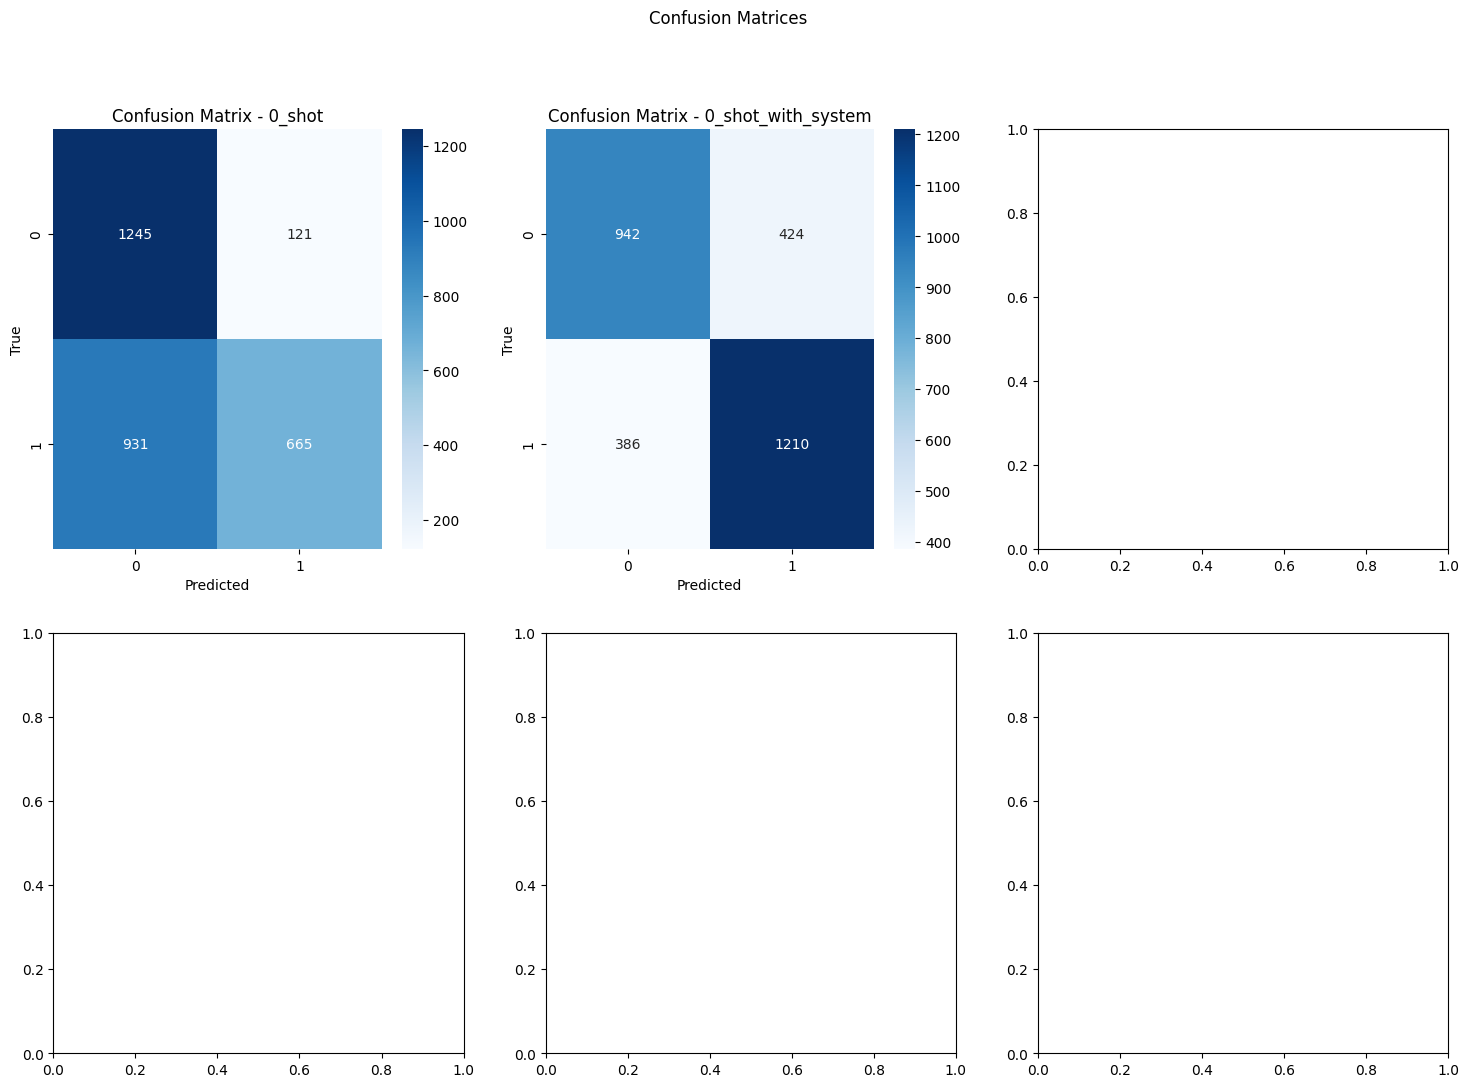

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(ax, df, true_labels_column, predicted_labels_column,
                          title=None
                          ):
    predicted_labels = df[f'{predicted_labels_column}']
    true_labels = df[f'{true_labels_column}']

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)


    # Display confusion matrix heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True,
                yticklabels=True, ax=ax)

    title = title if title else predicted_labels_column

    ax.set_title(f'Confusion Matrix - {title}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')


# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrices')

# Plot each confusion matrix
plot_confusion_matrix(axes[0, 0], df_merge_all_runs, 'label', '0_shot_label', '0_shot')
plot_confusion_matrix(axes[0, 1], df_merge_all_runs, 'label',
                      '0_shot_with_system_label', '0_shot_with_system')
plot_confusion_matrix(axes[0, 2], df_merge_all_runs, 'label', '0_shot_cot_label',
                      '0_shot_cot')
plot_confusion_matrix(axes[1, 0], df_merge_all_runs, 'label', '2_shot_label', '2_shot')
plot_confusion_matrix(axes[1, 1], df_merge_all_runs, 'label', '4_shot_label', '4_shot')
plot_confusion_matrix(axes[1, 2], df_merge_all_runs, 'label', '8_shot_label', '8_shot')

plt.tight_layout(
    rect=[0, 0, 1, 0.96])  # Adjust layout to prevent title overlap
plt.show()

# Krippendorff Alpha in model

In [ ]:
import krippendorff

runs = ['0_shot_label', '0_shot_with_system_label', '0_shot_cot_label',
        '2_shot_label', '4_shot_label', '8_shot_label']


def compute_krippendorff_alpha(df, predicted_columns):
    pred_map = {}
    for run in predicted_columns:
        predicted_labels = df[run]
        pred_map[run] = predicted_labels

    # Check if there is variability in the ratings
    unique_labels_counts = df[predicted_columns].nunique(axis=1)
    if unique_labels_counts.max() == 1:
        # All ratings are the same, return a special value or handle accordingly
        return 0

    reliability_data = df[predicted_columns].values.tolist()

    # Calculate Krippendorff's alpha
    alpha = krippendorff.alpha(reliability_data=list(pred_map.values()),
                               level_of_measurement='nominal')

    return alpha


In [ ]:
alpha_value = compute_krippendorff_alpha(df_merge, runs)
print(f"Krippendorff's Alpha (all runs): {alpha_value}")

In [ ]:
import itertools

def compute_krippendorff_alpha_for_k_runs(df, runs, k=None):
    # Initialize variables to store the best combination and alpha
    if k is None:
        k = len(runs)

    best_combination = None
    best_alpha = 0  # Assuming alpha ranges from 0 to 1

    # Iterate through all possible combinations
    for combination in itertools.combinations(runs, k):

        alpha_value = compute_krippendorff_alpha(df, list(combination))

        # Print alpha for the current combination
        print(f"Combination: {combination}, Alpha: {alpha_value}")

        # Update best combination and alpha if a higher alpha is found
        if alpha_value > best_alpha:
            best_alpha = alpha_value
            best_combination = combination

    # Print the best combination and alpha
    print(f"\nBest Combination: {best_combination}, Best Alpha: {best_alpha}")
    return best_alpha, best_combination

In [ ]:
compute_krippendorff_alpha_for_k_runs(df_merge, runs, 2)